In [14]:
import torch

from pathlib import Path

from transformers import GPT2Tokenizer, GPT2LMHeadModel, set_seed

from modular_transformers.models.gpt2.configuration_gpt2 import GPT2Config
from modular_transformers.models import components

import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

from tqdm import tqdm

In [15]:
#set seeds
torch.manual_seed(0)
np.random.seed(0)
set_seed(0)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
PCA_DIM = 2
PERTUBATION_WEIGHT = 0.1
num_bigrams = 1000

### Make matrix of activations for each layer for 10000 bigrams

In [18]:
bigram_text = open("bigrams.txt", "r").read().split("\n")
bigrams = [(int(b[b.find('\t')+1:]), b[:b.find('\t')]) for b in bigram_text if len(b) > 0]
bigrams.sort(key=lambda x: x[0], reverse=True)
bigrams = bigrams[:num_bigrams]

tokenizer = GPT2Tokenizer.from_pretrained("gpt2", fast=False)
bigram_tokens = [tokenizer.encode(b[1]) for b in bigrams]
max_token_num = max([len(b) for b in bigram_tokens])

In [19]:
#tiny model
# bottleneck_dim = 4
# n_layer = 12

# config = {'vocab_size': len(tokenizer), 'n_ctx': 1024, 'bos_token_id': tokenizer.bos_token_id,
#                     'eos_token_id': tokenizer.eos_token_id, "bottleneck": bottleneck_dim, "n_layer": n_layer}
# config = GPT2Config(config)
# config.n_embds = [768, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
# orig_model = components.LM(config)
# orig_model.to(device)

In [20]:
#small model
# save_dir = Path(f'/om2/user/jackking/MyData/mt/miniberta_100M/768-768-768/reg_loss/checkpoint_216000')
# orig_model = components.LM.from_pretrained(save_dir)
# moorig_modeldel.to(device)

In [21]:
#big model
orig_model = GPT2LMHeadModel.from_pretrained("gpt2")
orig_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [22]:
token_selection = np.random.randint(len(bigram_tokens), size=25)

In [23]:
def sample_outputs(models):
    random_bigram_selection = [bigram_tokens[i] for i in token_selection]
    for bigram in random_bigram_selection:
        for model in models:
            input = torch.tensor(bigram).to(device)
            output = model(input)
            prediction = output.logits[-1, :].argmax(dim=-1)
            tokenized = tokenizer.decode(prediction)
            print(tokenizer.decode(bigram) + "->" + tokenized)

In [24]:
def register_monitoring_hooks(model, activations):
    def hook_wrapper(layer):
        def hook_function(module, input, output):
            for i in range(output.shape[1]):
                activations[i][layer].append(output[:, i, :].detach().cpu())
        return hook_function

    for i, layer in enumerate(model.transformer.h):
        layer.mlp.c_proj.register_forward_hook(hook_wrapper(i))


In [25]:
def make_activation_matrix(activations, max_token_num):
    final = [[[] for _ in range(len(orig_model.transformer.h))] for _ in range(max_token_num)]
    for token_num, acts in enumerate(activations):
        if len(acts[0]) < 2:
            final = final[:token_num]
            max_token_num = token_num
            break
        for layer, layer_acts in enumerate(acts):
            matrix = torch.stack(layer_acts, dim=0).squeeze()
            final[token_num][layer] = matrix
    return final

In [26]:
activations = [[[] for _ in range(len(orig_model.transformer.h))] for _ in range(max_token_num)]
register_monitoring_hooks(orig_model, activations)

for bigram in tqdm(bigram_tokens):
    input = torch.tensor(bigram).unsqueeze(0).to(device)
    output = orig_model(input)

orig_activations = make_activation_matrix(activations, max_token_num)

100%|██████████| 1000/1000 [00:08<00:00, 115.07it/s]


In [27]:
# torch.save(orig_activations, 'test_activations.pt')

### Find principal axes to perturb along

In [28]:
def get_pcas(activations):
    pcas = [[None for _ in range(len(orig_model.transformer.h))] for _ in range(max_token_num)]
    for token_num, acts in enumerate(activations):
        for layer, matrix in enumerate(acts):
            pca = PCA()
            if not isinstance(matrix, list):
                matrix = matrix.detach().cpu().numpy()
            else:
                matrix = np.array(matrix).reshape(1, -1)
            pca.fit(matrix)
            pcas[token_num][layer] = pca
    return pcas

In [29]:
#load
# orig_activations = torch.load('test_activations.pt')
orig_pcas = get_pcas(orig_activations)

In [30]:
#visualize
def plot_pca(token_num, activations, pcas):
    ax, fig = plt.subplots(figsize=(16, 13), nrows=4, ncols=6)
    for layer, pca in enumerate(pcas):

        data = pca.transform(activations[token_num][layer].detach().cpu().numpy())
        variance = pca.explained_variance_ratio_

        #visualize components
        fig[(layer*2)//6, (layer*2)%6].scatter(data[:, 0], data[:, 1])
        fig[(layer*2)//6, (layer*2)%6].set_title(f'Layer {layer}')

        #visualize variance with cumulative sum
        fig[(layer*2)//6, (layer*2)%6 + 1].plot(range(len(variance)), variance.cumsum())
        fig[(layer*2)//6, (layer*2)%6 + 1].set_ylim(0, 1)
        fig[(layer*2)//6, (layer*2)%6 + 1].set_title(f'Layer {layer}')

    plt.show()

Token 0


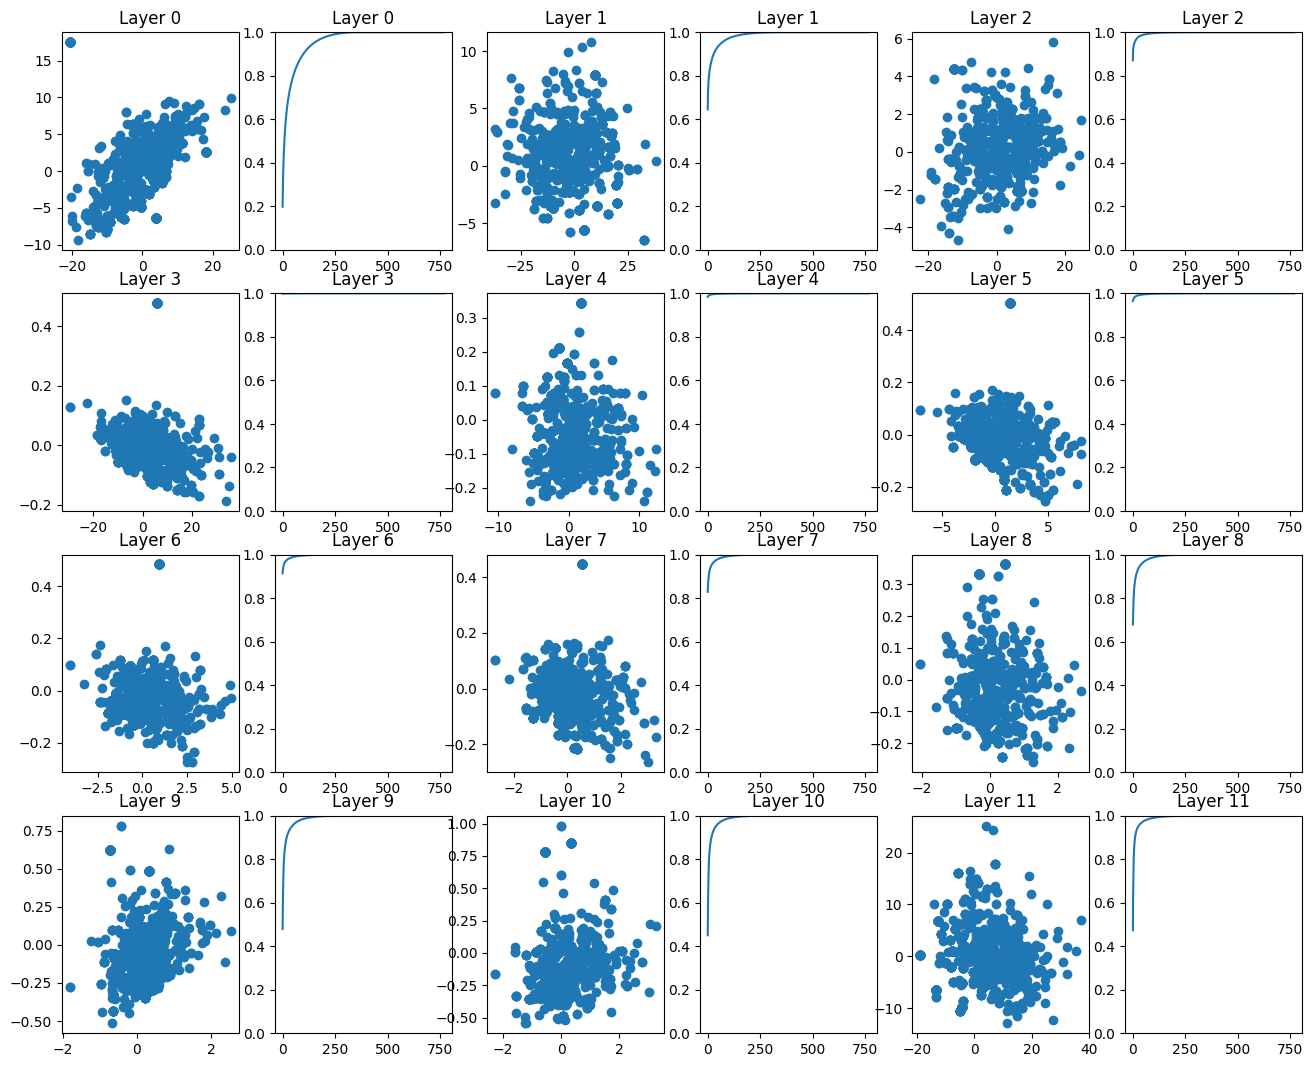

Token 1


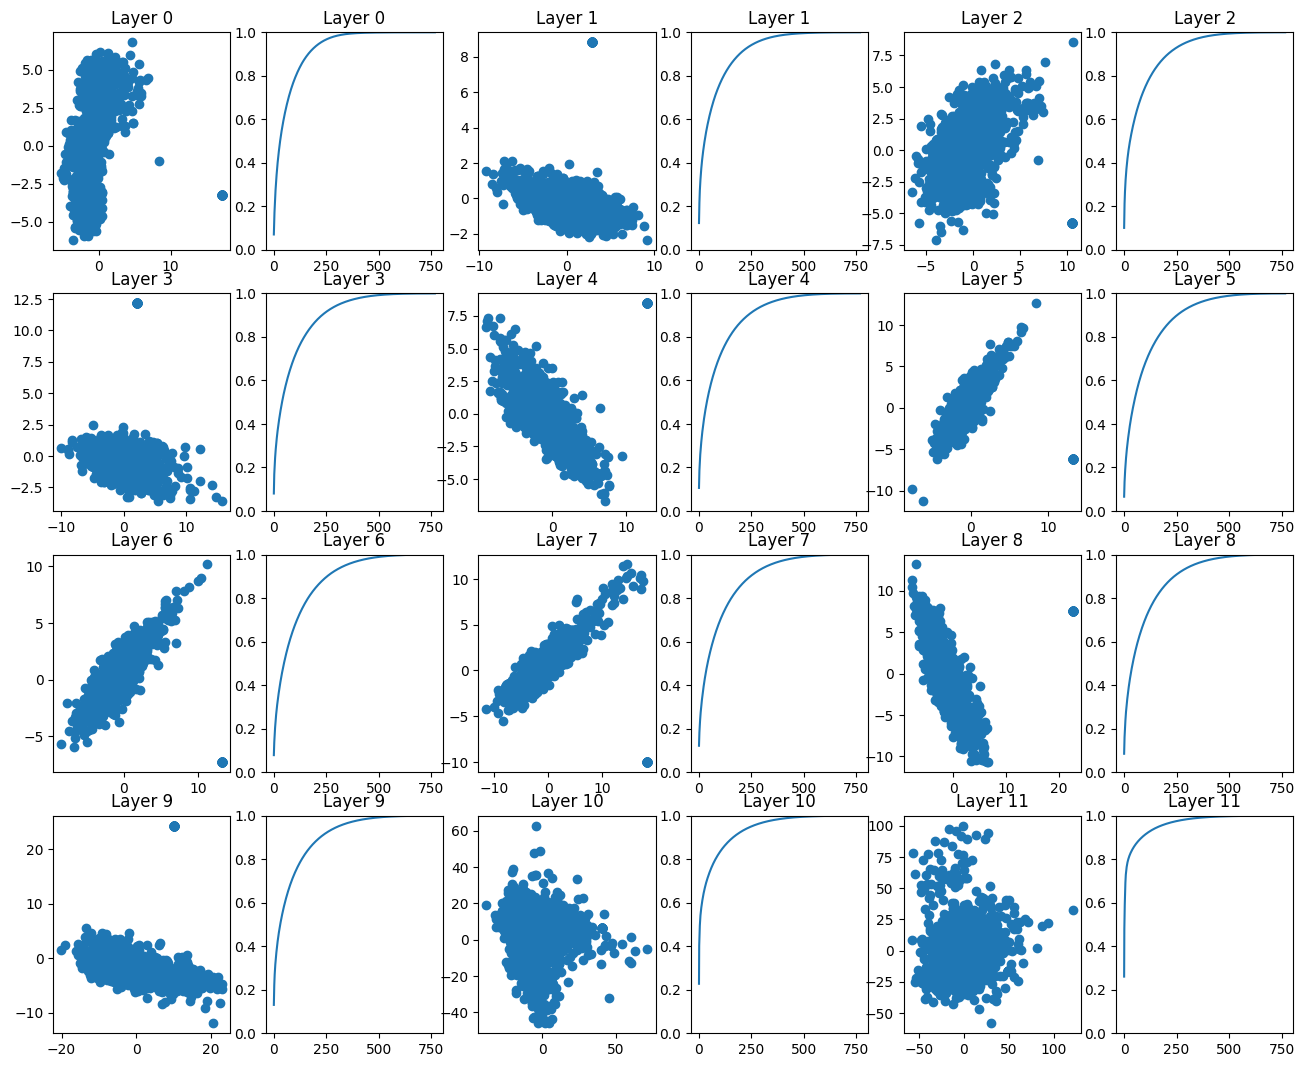

Token 2


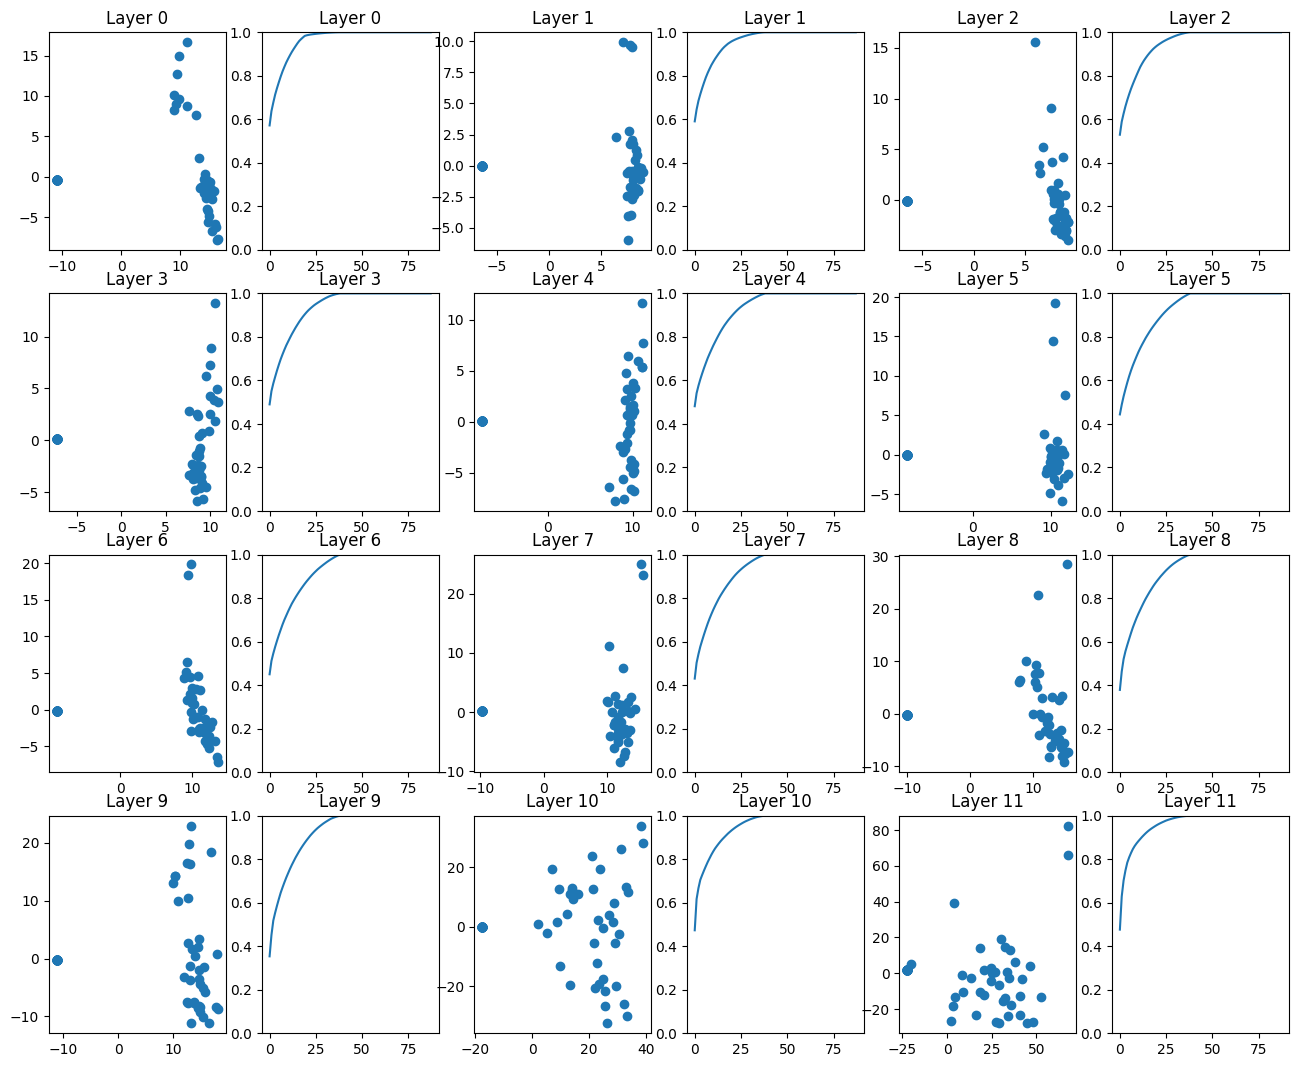

Token 3


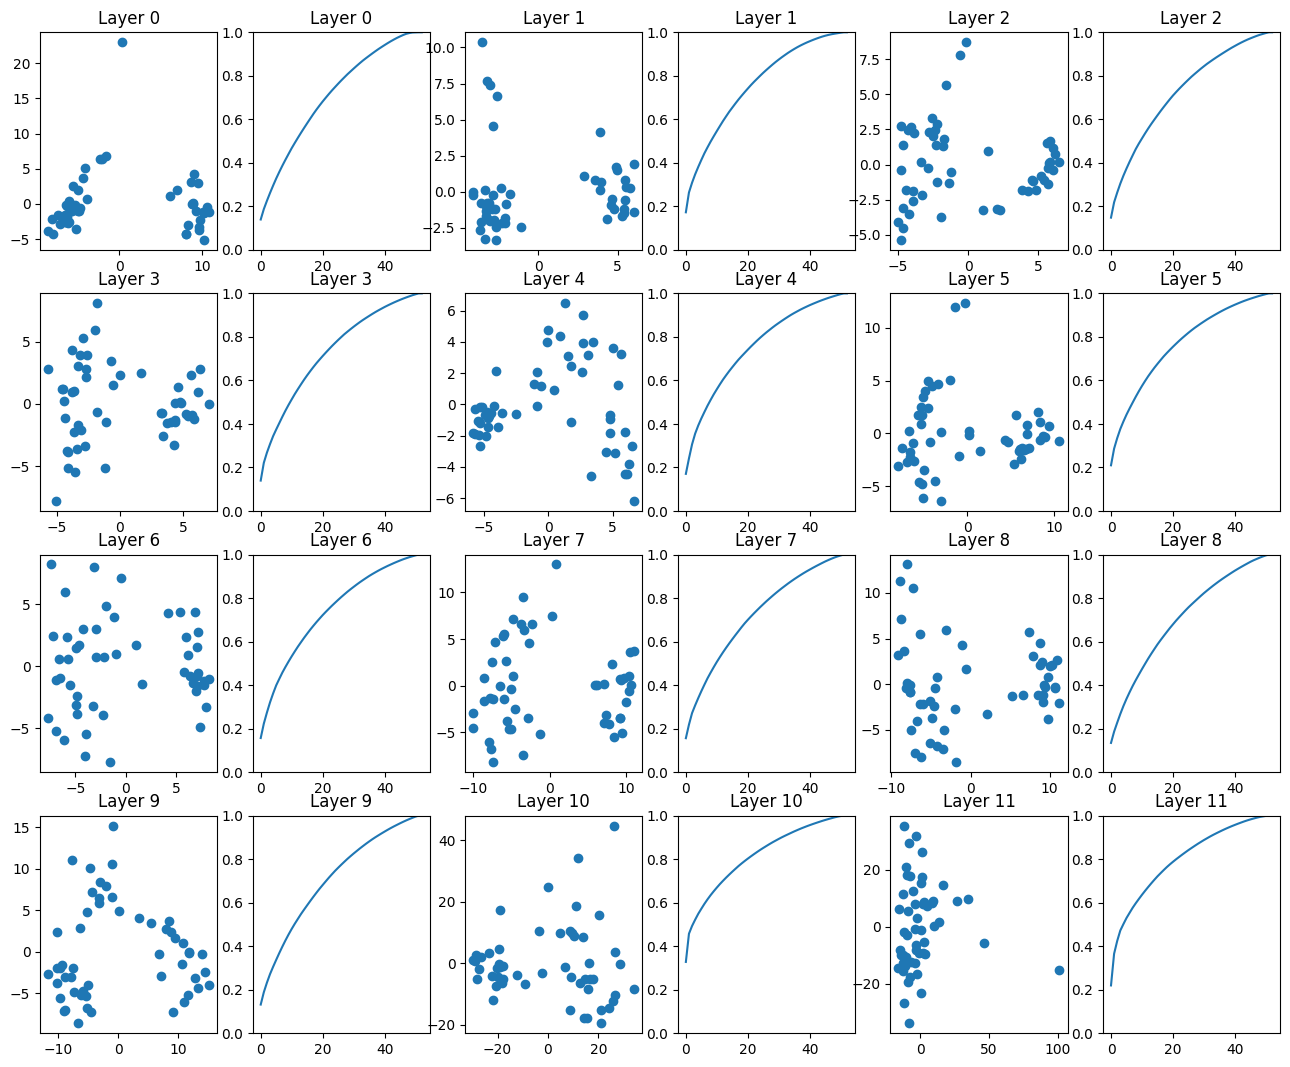

Token 4


AttributeError: 'NoneType' object has no attribute 'transform'

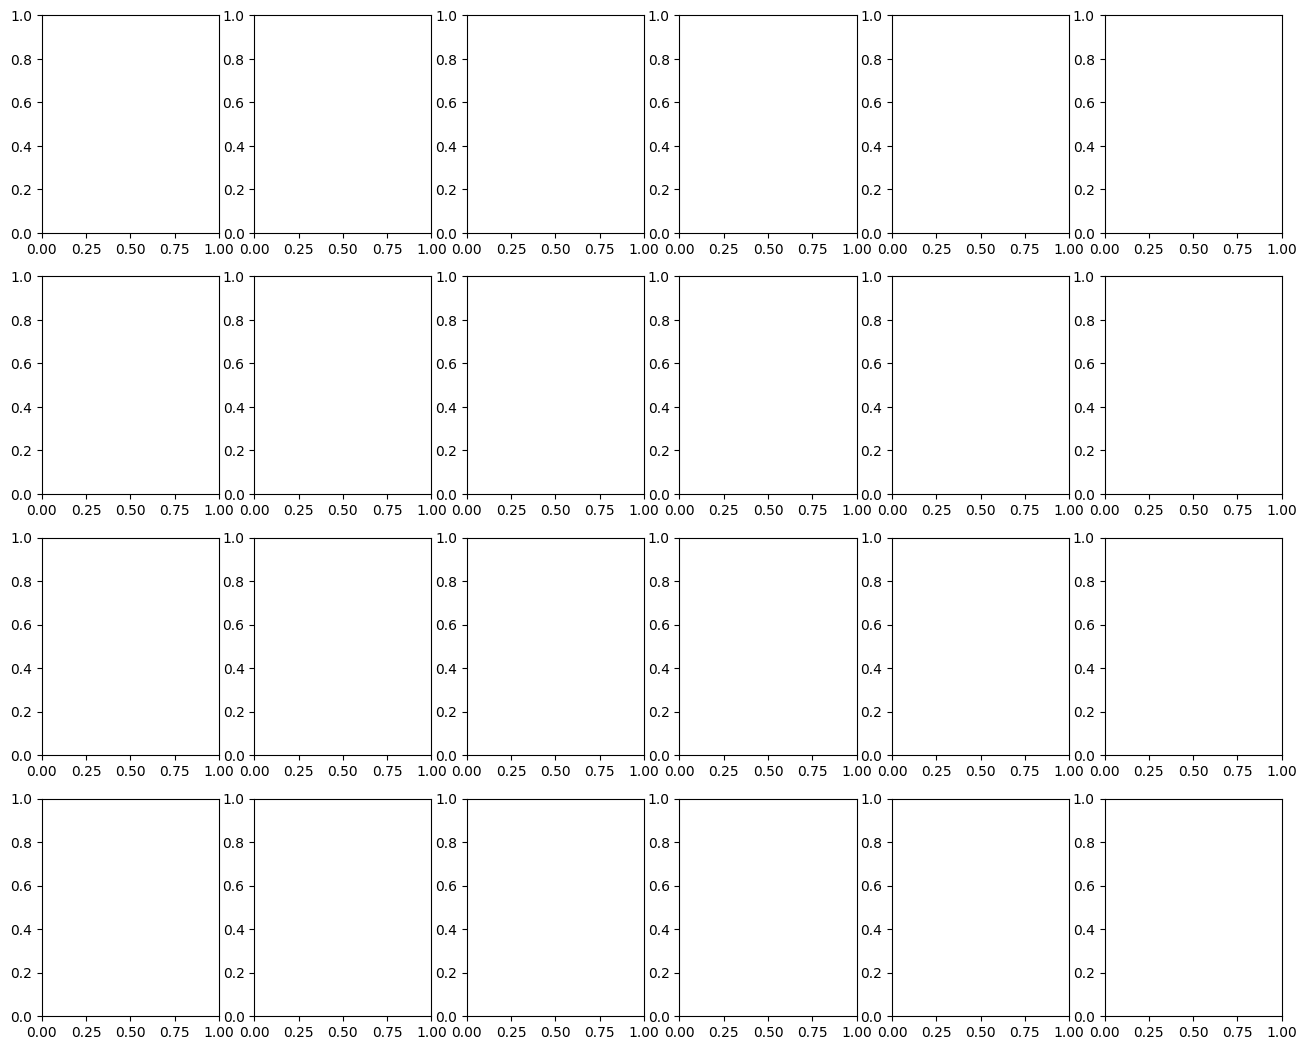

In [31]:
for token_num, pca in enumerate(orig_pcas):
    print(f'Token {token_num}')
    plot_pca(token_num, orig_activations, pca)

In [ ]:
#find the number of components needed to explain a baseline variance as well as a universal cutoff
num_components = [[{} for _ in range(len(orig_model.transformer.h))] for _ in range(max_token_num)]
for token_num, layers_pcas in enumerate(orig_pcas):
    for layer, pca in enumerate(layers_pcas):
        variance = pca.explained_variance_ratio_
        for i, v in enumerate(variance.cumsum()):
            if v > 0.8:
                num_components[token_num][layer]["explained_cutoff"] = i
                break
        if len(variance) < PCA_DIM:
            num_components[token_num][layer]["cutoff"] = len(variance)
        else:
            num_components[token_num][layer]["cutoff"] = PCA_DIM

### Perturb along principal axes

In [ ]:
perturbed_model = GPT2LMHeadModel.from_pretrained("gpt2")
perturbed_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [ ]:
# model = components.LM(config)
# model.to(device)

In [ ]:
def register_pertubation_hooks(model):
    def hook_wrapper(pertubations):
        def prehook(module, input):
            # print("perturbing")
            for i in range(input[0].shape[1]):
                # print(input[0][:, i, :])
                pertubation = pertubations[i]
                # print("pert 1: ", pertubation)
                pertubation = torch.tensor(pertubation * np.random.normal(loc=1, scale = PERTUBATION_WEIGHT)).to(device)
                # pertubation = torch.tensor(pertubation * np.random.normal(loc=1, scale = PERTUBATION_WEIGHT)).to(device)
                # pertubation = torch.randn_like(torch.tensor(pertubation)).to(device)
                # print("pert 2: ", pertubation)
                input[0][:, i, :] += pertubation
                # print(input[0][:, i, :])
            return input
        return prehook

    #shuffle for different indexing
    reshuffled_pcas = [{} for _ in range(len(orig_pcas[0]))]
    for token_num, layers_pcas in enumerate(orig_pcas):
        for layer, pca in enumerate(layers_pcas):
            reshuffled_pcas[layer][token_num] = pca
    
    for layer, layer_pcas in enumerate(reshuffled_pcas):
        pertubations = []
        # print("layer ", layer)
        for token_num, pca in layer_pcas.items():
            nc = num_components[token_num][layer]["cutoff"]
            pc = pca.components_[:nc, :]
            # print(pc.shape)
            pertubation = pc.sum(axis=0) / nc
            pertubation = pertubation / np.linalg.norm(pertubation)
            pertubations.append(pertubation)
        # print(len(pertubations))
        model.transformer.h[layer].mlp.dropout.register_forward_pre_hook(hook_wrapper(pertubations))


In [ ]:
perturbed_activations = [[[] for _ in range(len(perturbed_model.transformer.h))] for _ in range(max_token_num)]

register_monitoring_hooks(perturbed_model, perturbed_activations)
register_pertubation_hooks(perturbed_model)

for bigram in tqdm(bigram_tokens):
    input = torch.tensor(bigram).unsqueeze(0).to(device)
    output = perturbed_model(input)

perturbed_activations = make_activation_matrix(perturbed_activations)

 17%|█▋        | 1723/10000 [00:21<01:44, 79.34it/s]

 27%|██▋       | 2672/10000 [00:33<01:32, 79.54it/s]


KeyboardInterrupt: 

In [ ]:
# torch.save(perturbed_activations, 'gpt2_perturbed_activations.pt')

In [ ]:
#load
# perturbed_activations = torch.load('gpt2_perturbed_activations.pt')
perturbed_pcas = get_pcas(perturbed_activations)

Token 0


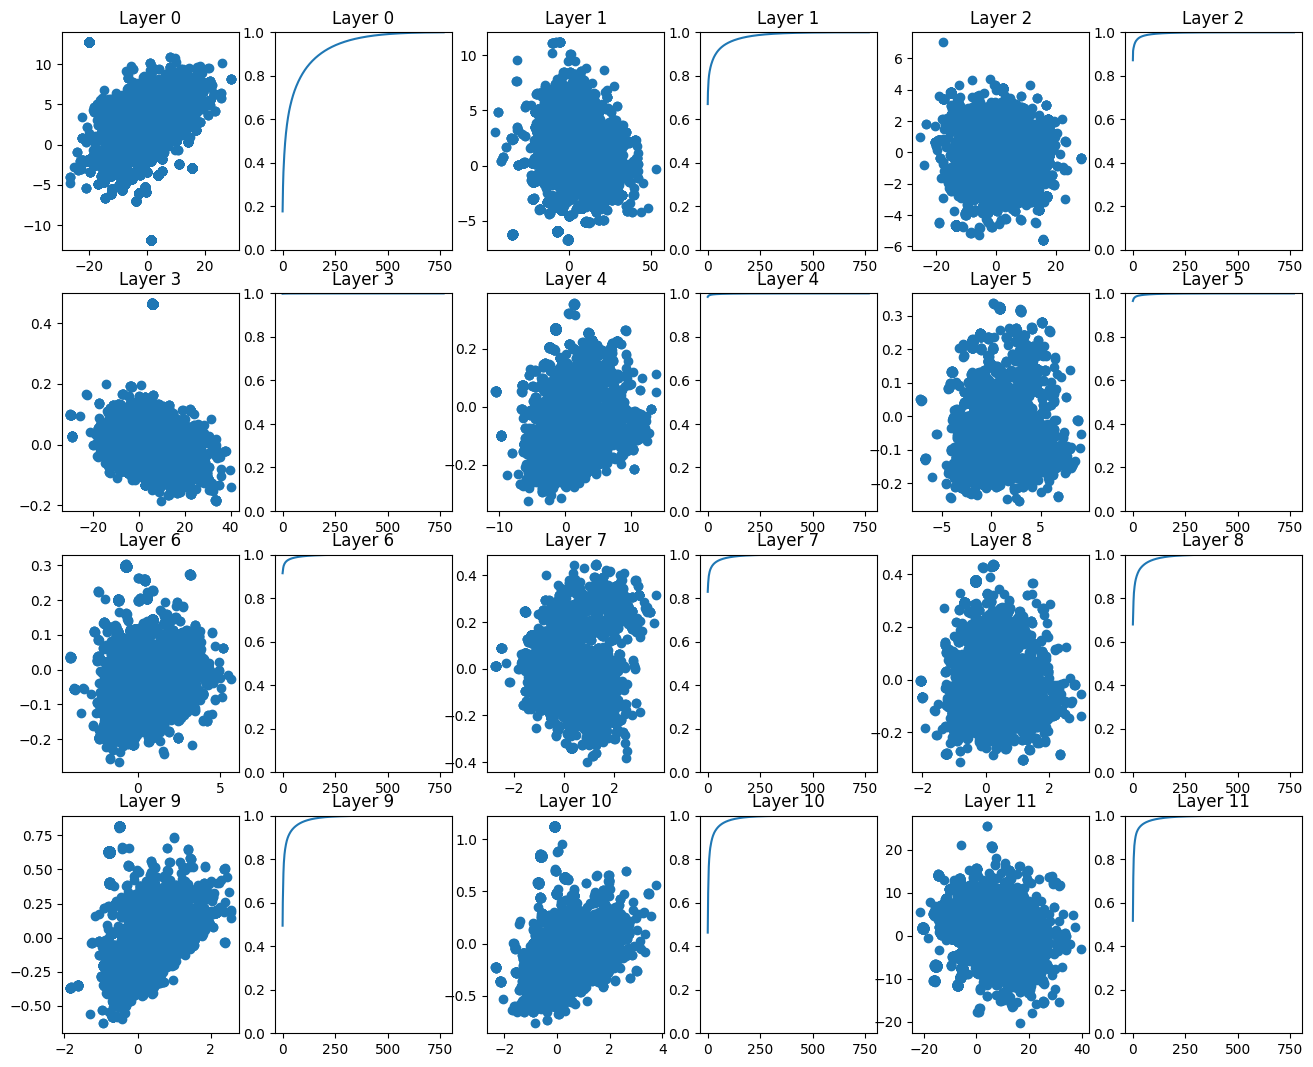

Token 1


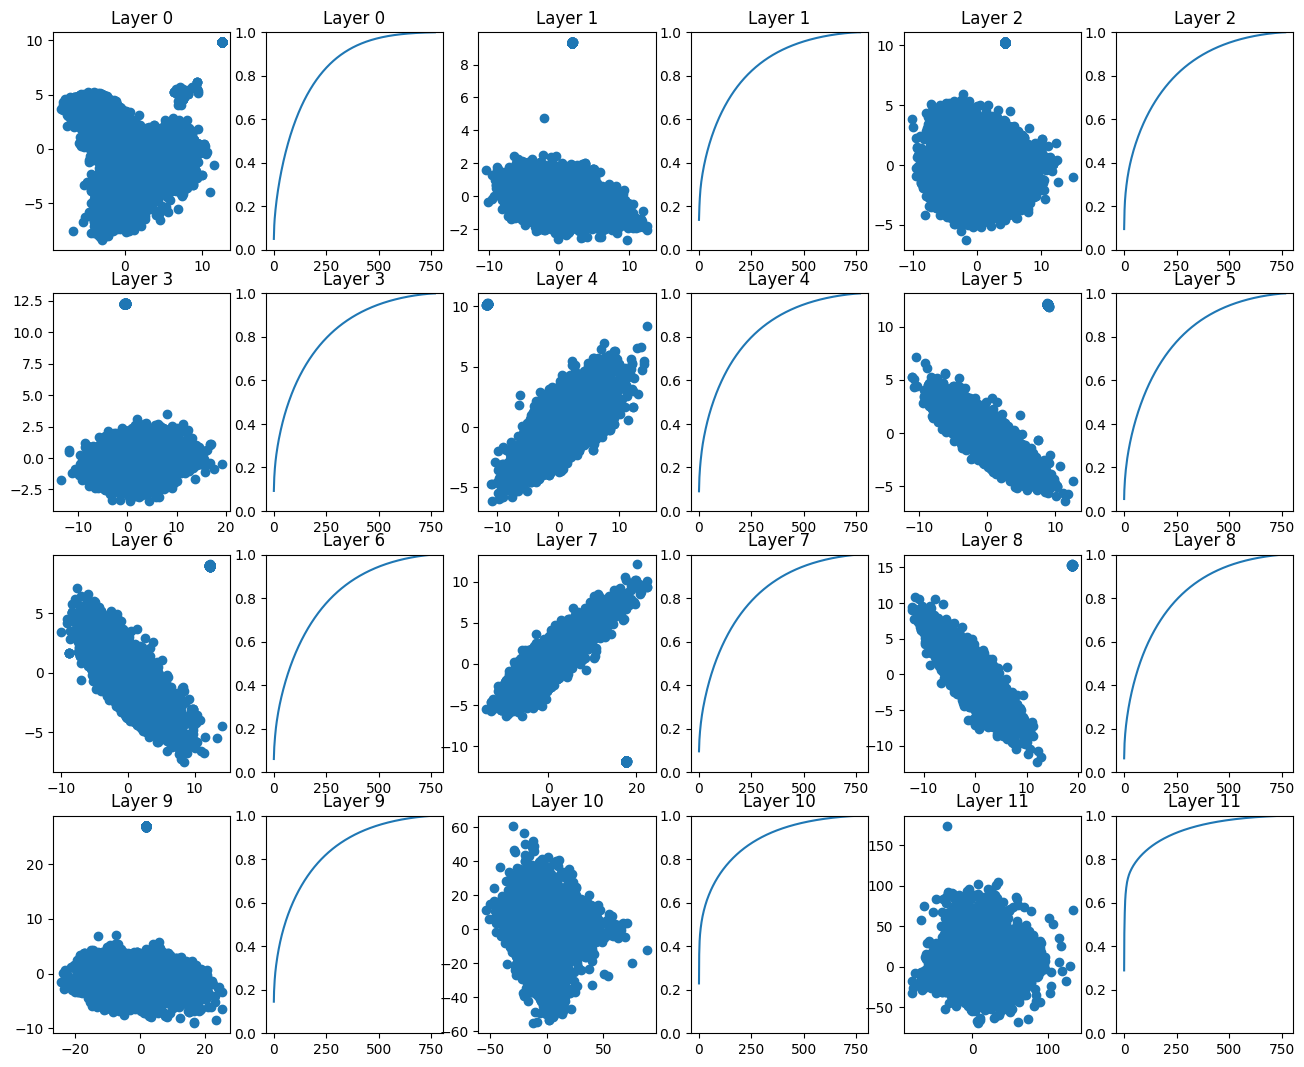

Token 2


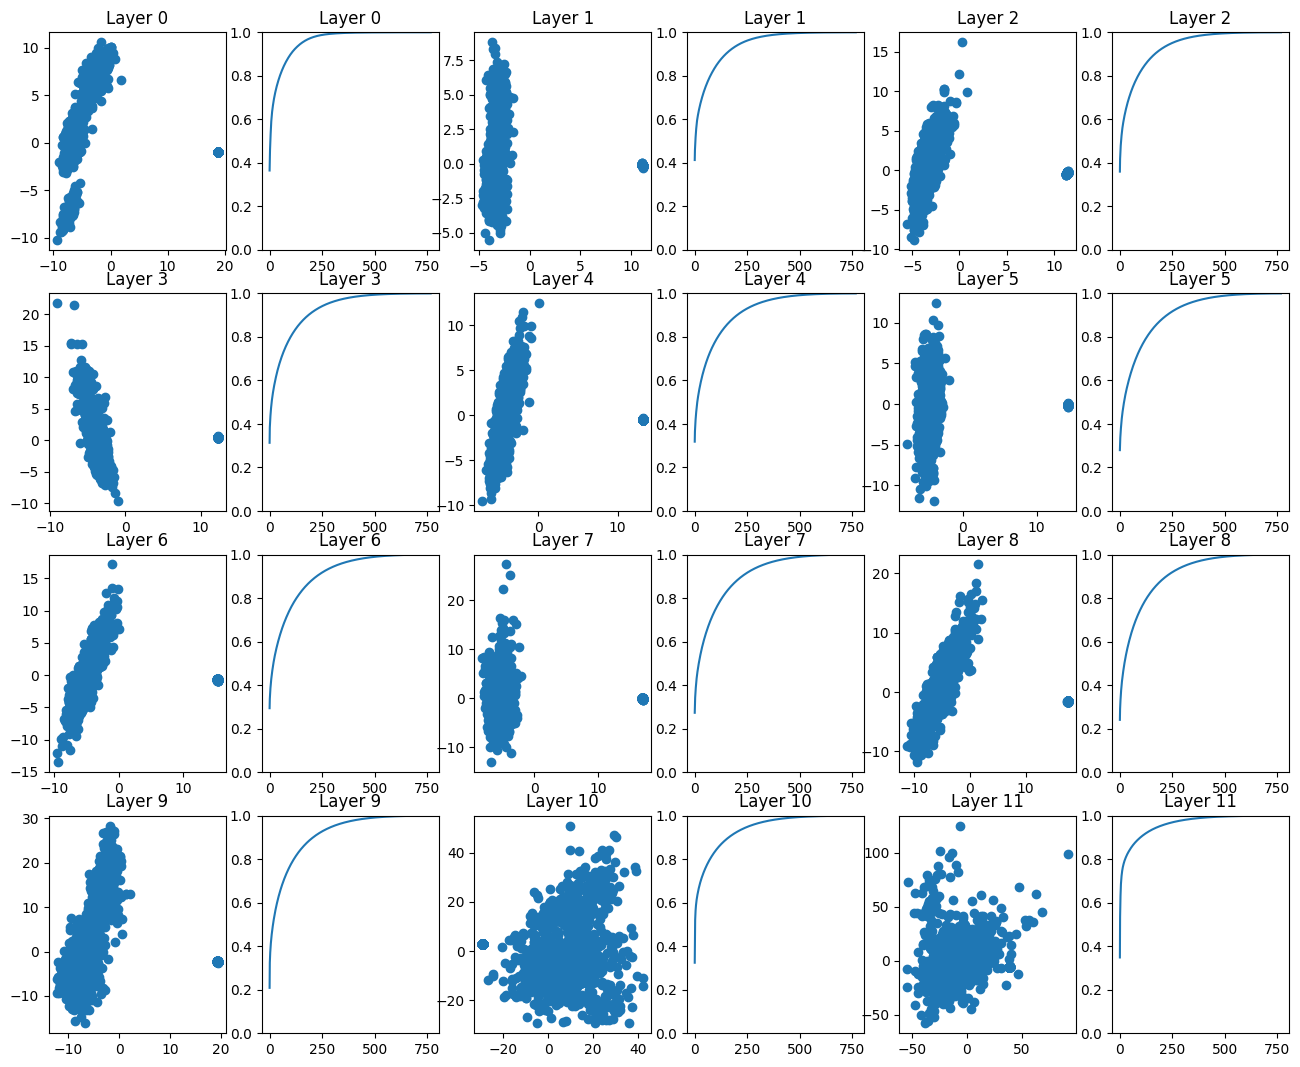

Token 3


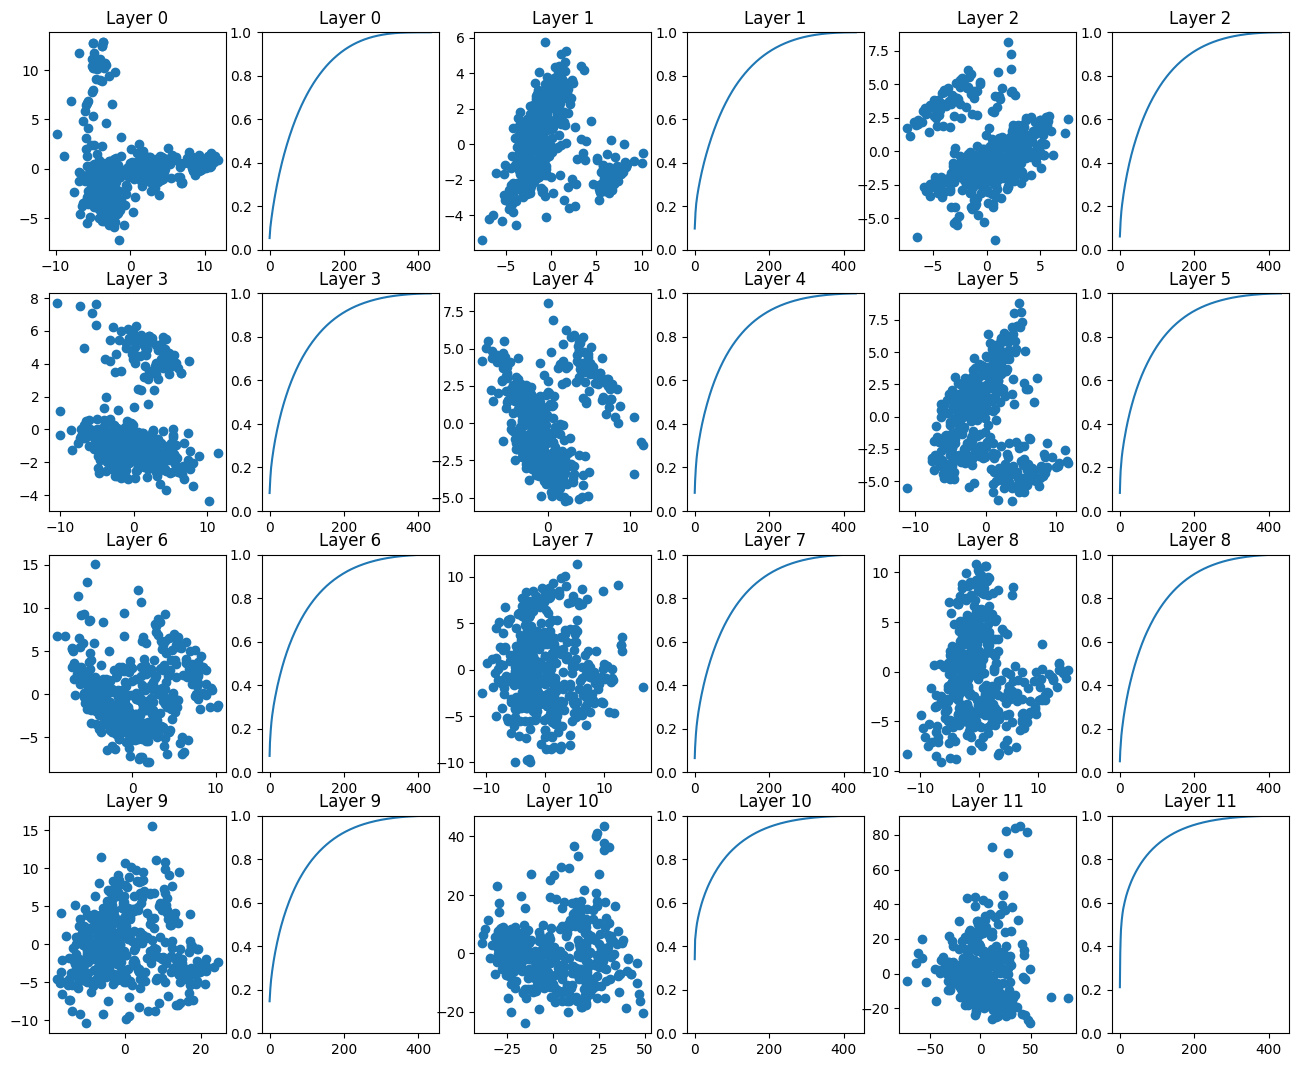

Token 4


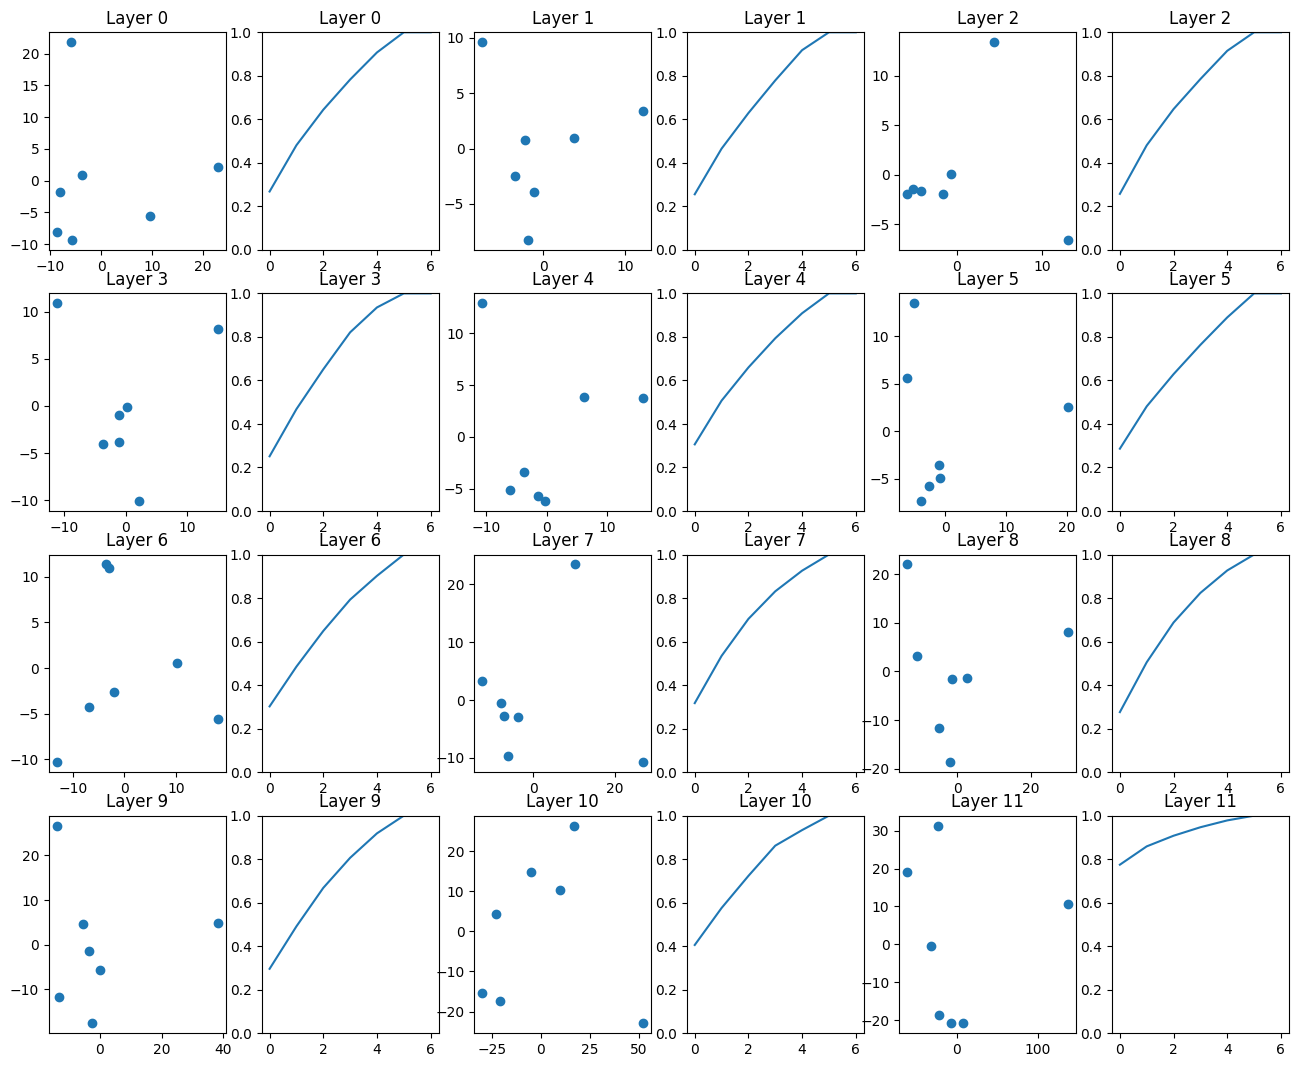

Token 5


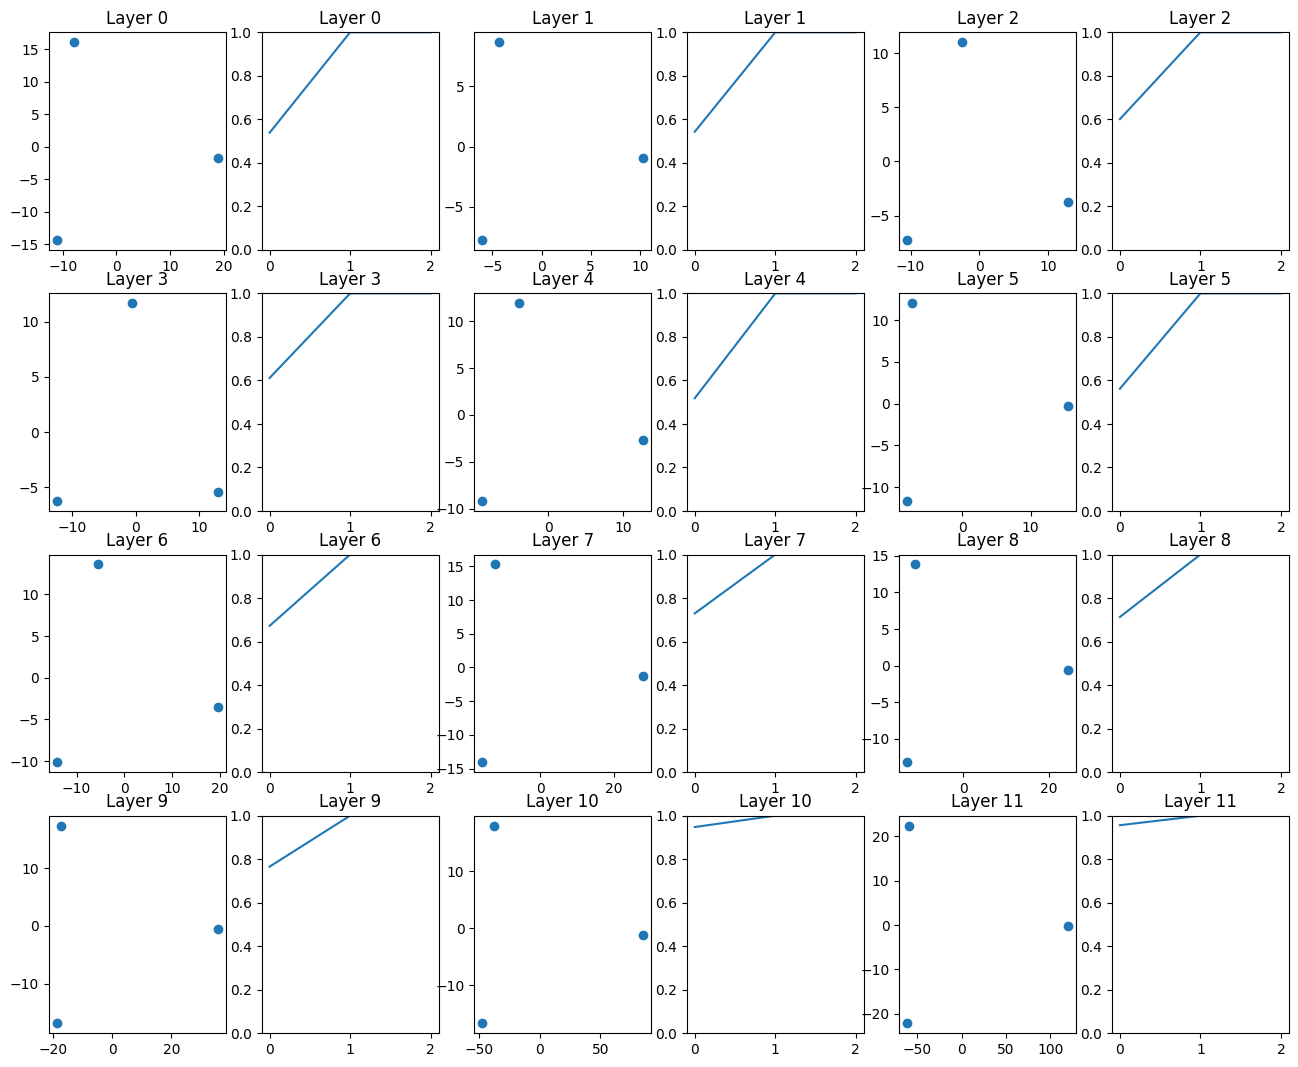

In [ ]:
#visualize perturbed activations
for token_num, pca in enumerate(perturbed_pcas):
    print(f'Token {token_num}')
    plot_pca(token_num, perturbed_activations, pca)

In [ ]:
#visualize
def plot_pca_sidebyside(token_num, orig_pcas, perturbed_pcas):
    ax, fig = plt.subplots(figsize=(16, 13), nrows=4, ncols=6)
    for layer, (orig_pca, perturbed_pca) in enumerate(zip(orig_pcas, perturbed_pcas)):

        orig_data = orig_pca.transform(orig_activations[token_num][layer].detach().cpu().numpy())
        perturbed_data = perturbed_pca.transform(perturbed_activations[token_num][layer].detach().cpu().numpy())

        #visualize orig components
        fig[(layer*2)//6, (layer*2)%6].scatter(orig_data[:, 0], orig_data[:, 1])
        fig[(layer*2)//6, (layer*2)%6].set_title(f'Original Layer {layer}')

        #visualize perturbed components
        fig[(layer*2)//6, (layer*2)%6 + 1].scatter(perturbed_data[:, 0], perturbed_data[:, 1])
        fig[(layer*2)//6, (layer*2)%6 + 1].set_title(f'Perturbed Layer {layer}')

    plt.show()

Token 0


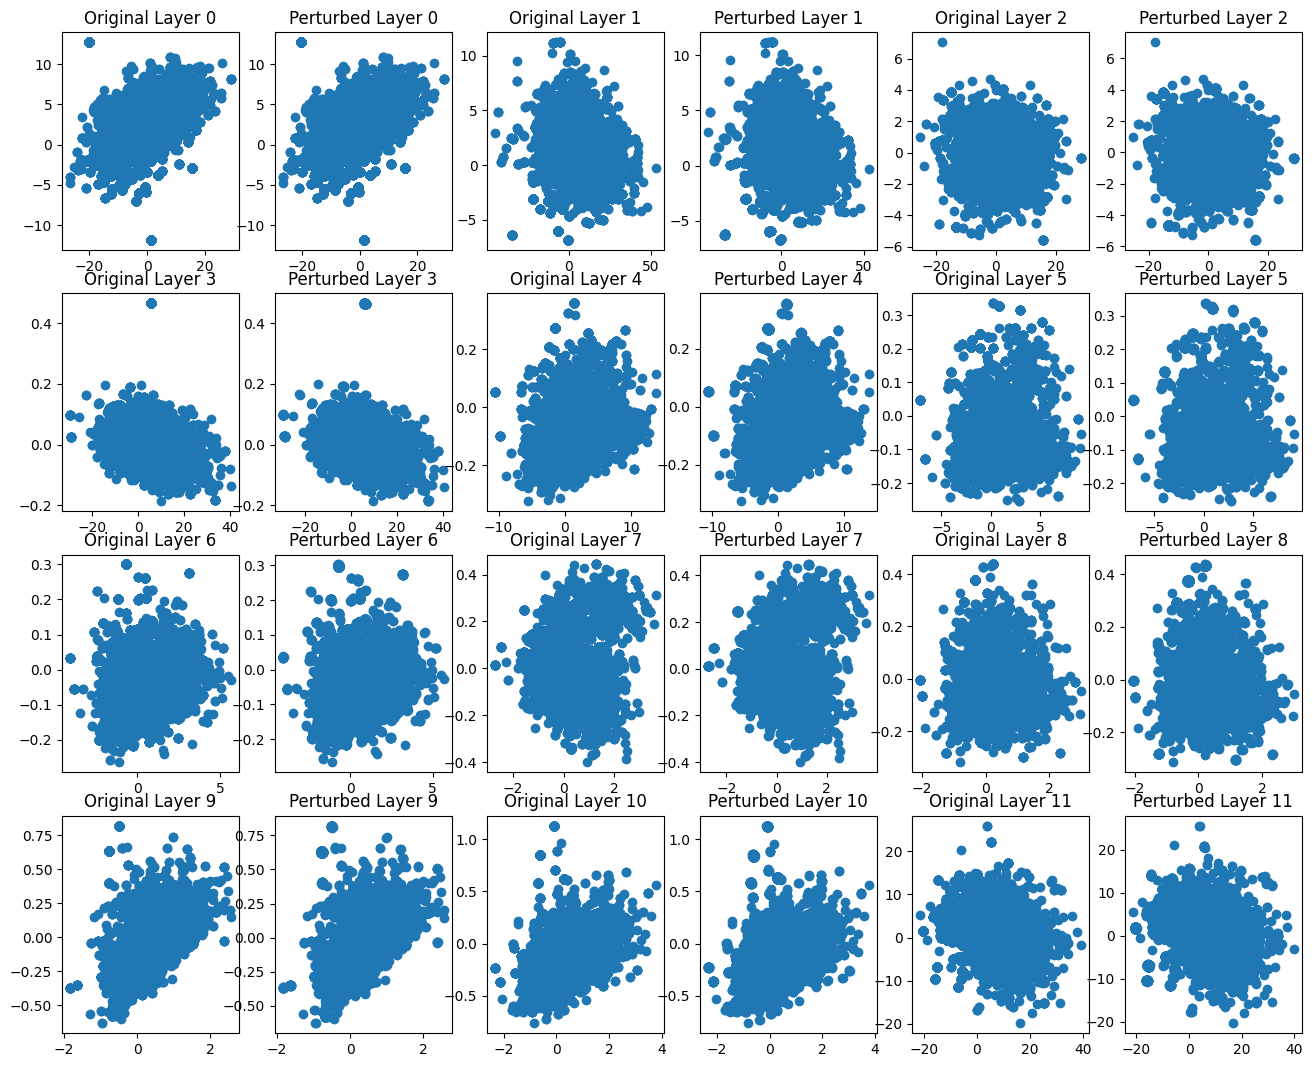

Token 1


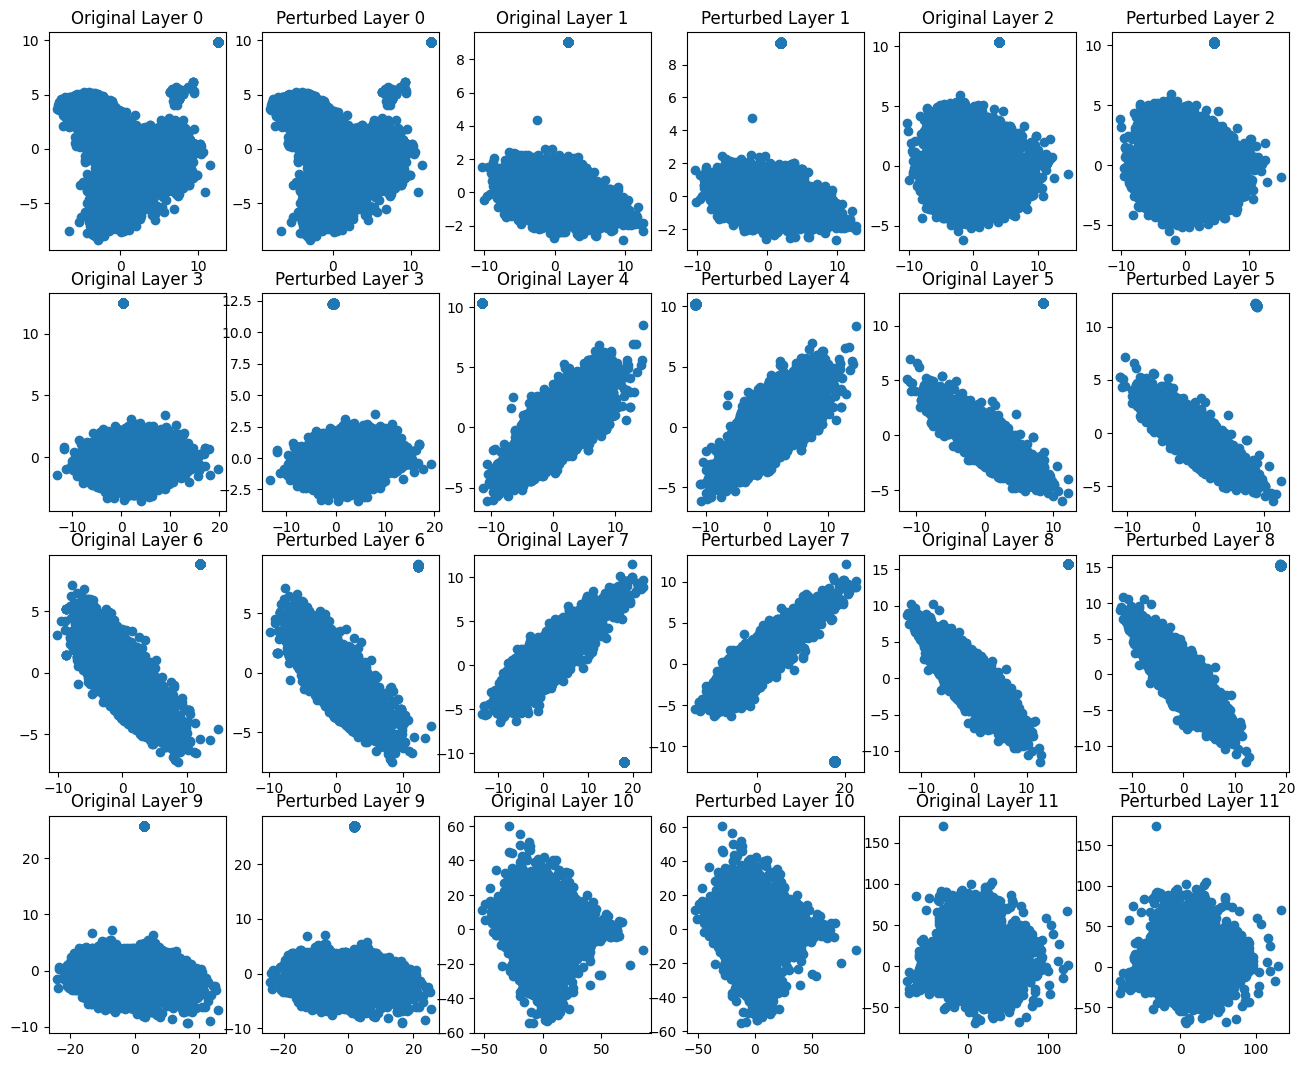

Token 2


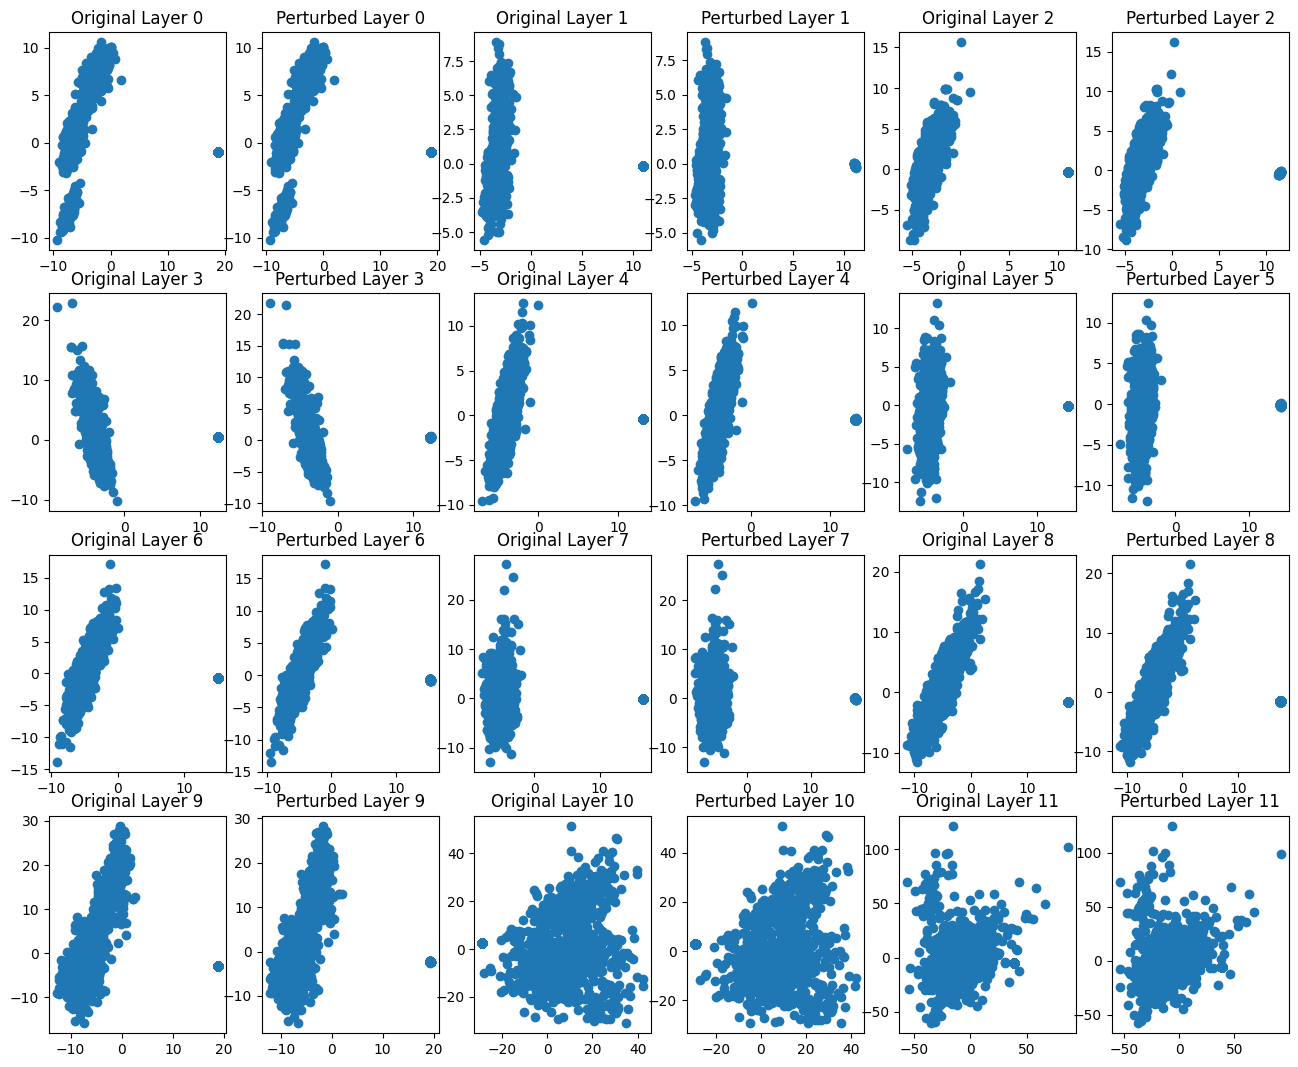

Token 3


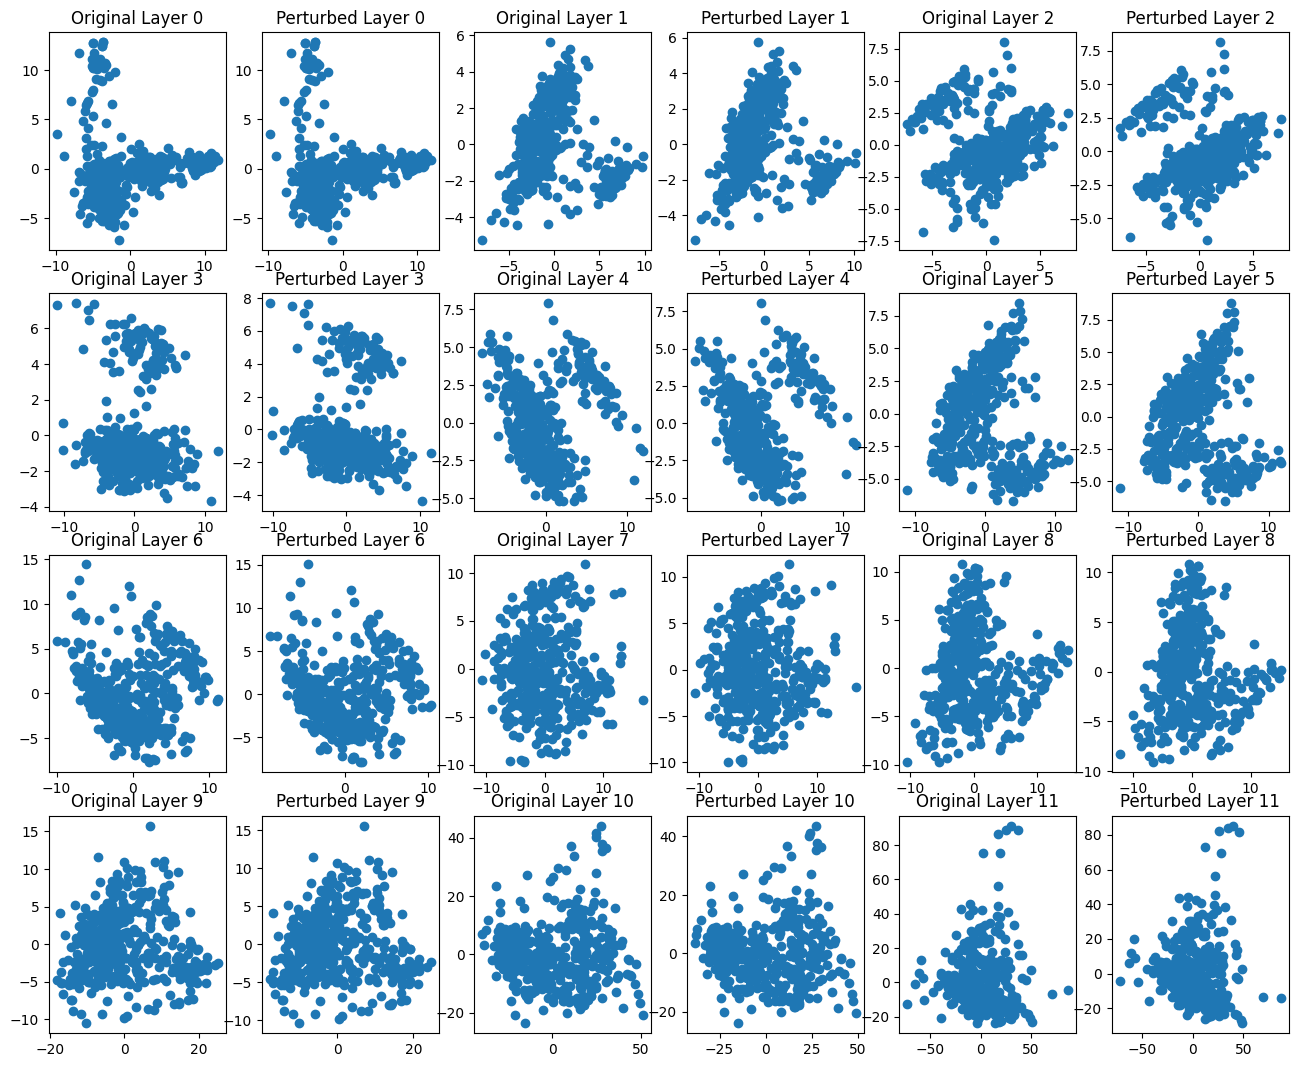

Token 4


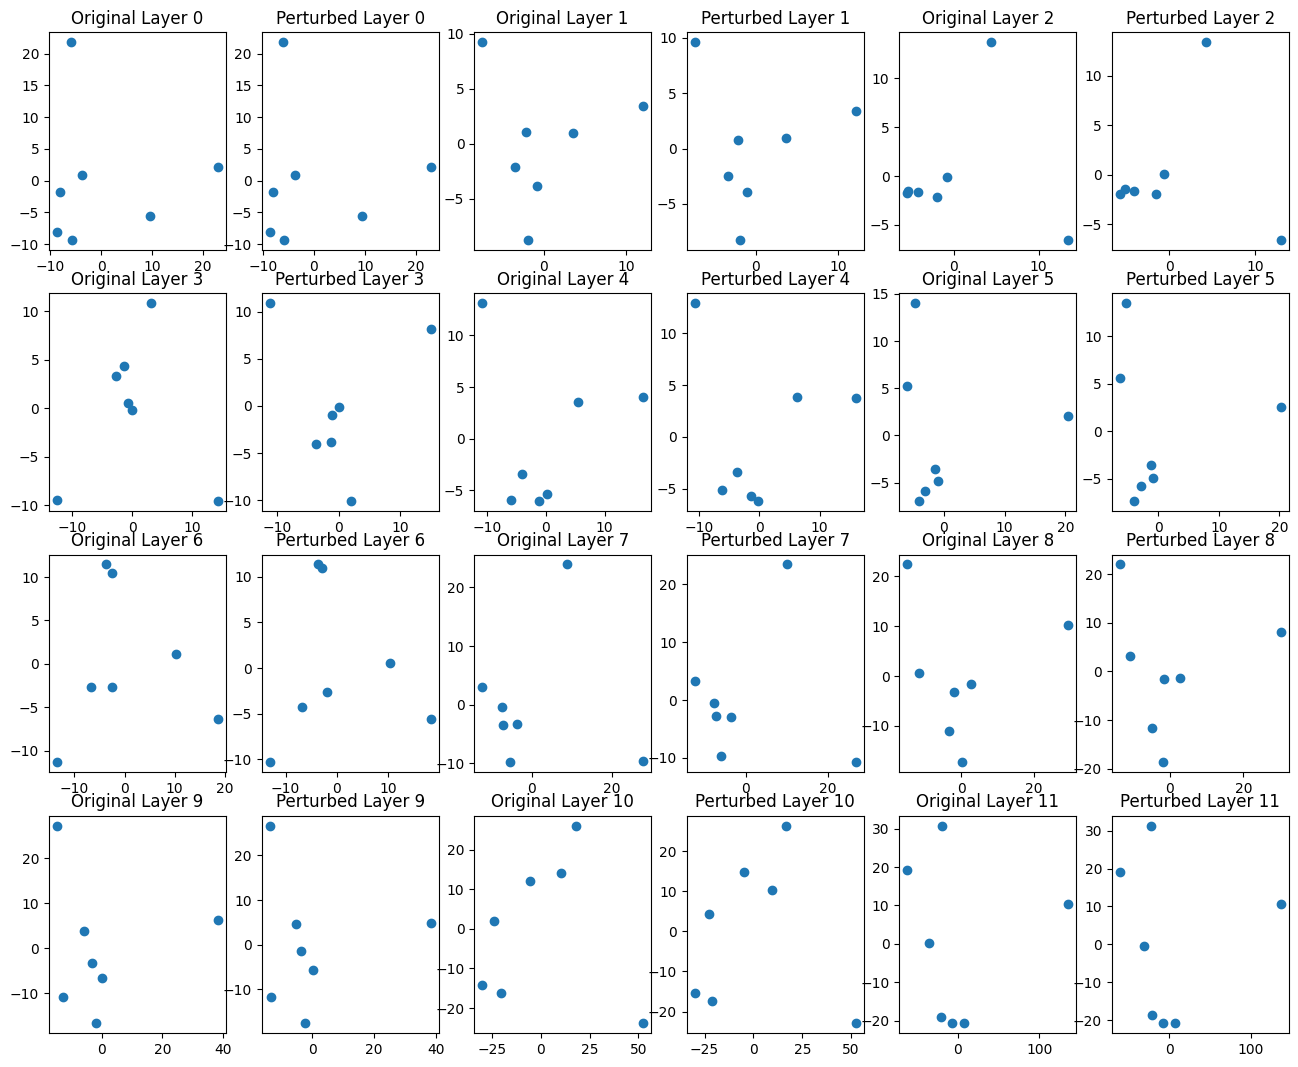

Token 5


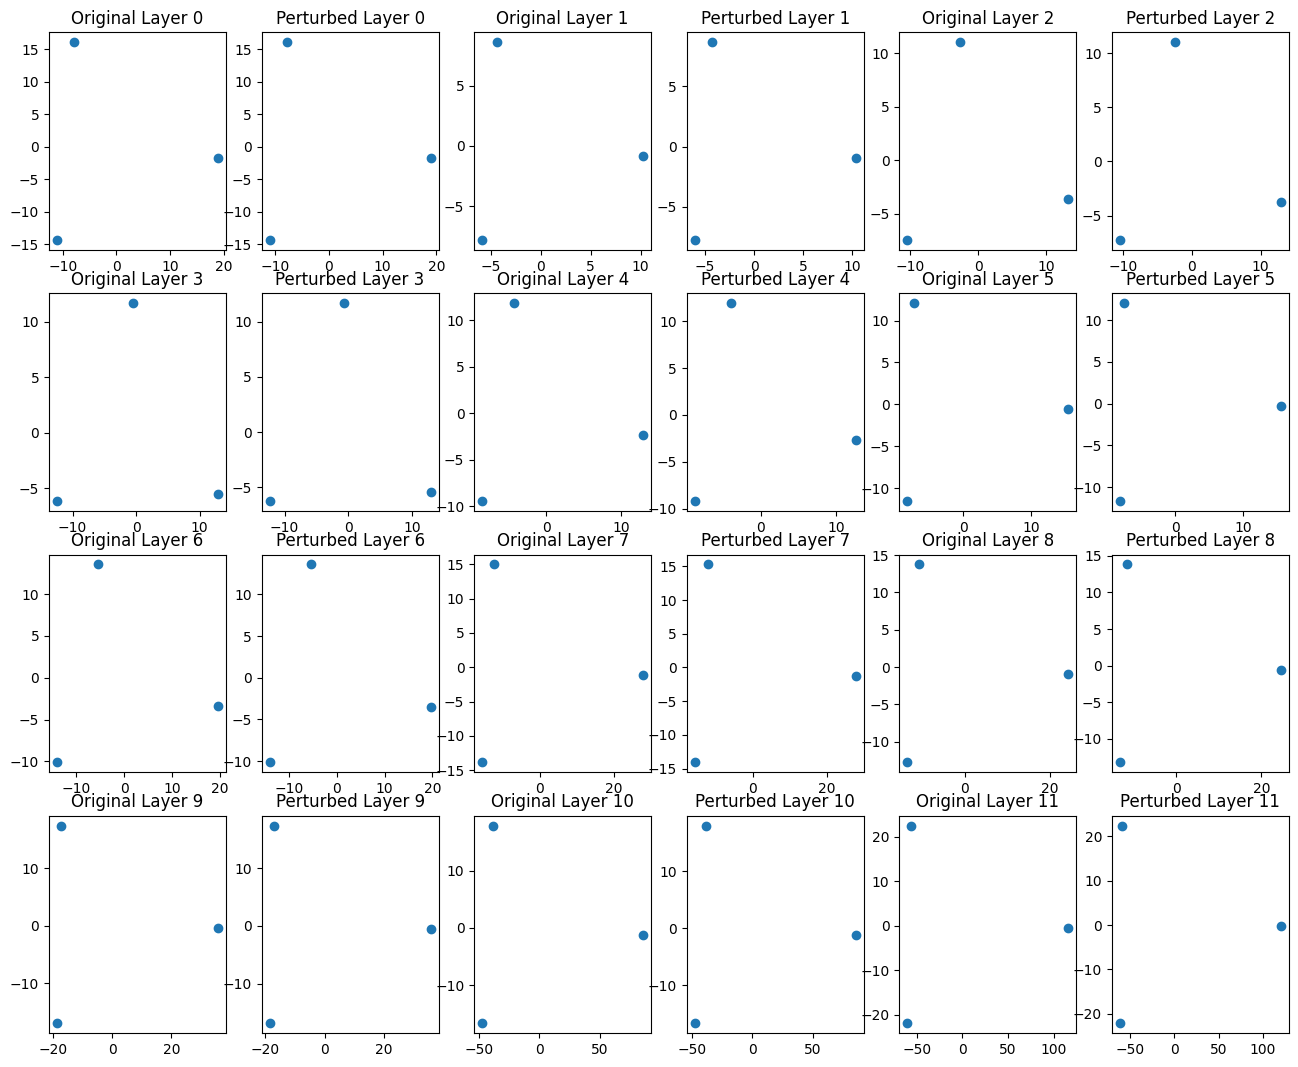

In [ ]:
#visualize perturbed activations next to original activations
for i in range(len(orig_pcas)):
    print(f'Token {i}')
    plot_pca_sidebyside(i, orig_pcas[i], perturbed_pcas[i])

In [ ]:
sample_outputs([perturbed_model, orig_model])

Free delivery->.
Free delivery->.
first one->,
first one->,
and were-> not
and were-> not
Ask a-> question
Ask a-> question
also had-> a
also had-> a
comes in-> the
comes in-> the
a maximum-> of
a maximum-> of
later than-> the
later than-> the
Description of-> the
Description of-> the
ask for-> a
ask for-> a
seems to-> be
seems to-> be
is often-> used
is often-> used
the design-> of
the design-> of
has more-> than
has more-> than
Review of-> the
Review of-> the
appears that-> the
appears that-> the
of which-> is
of which-> is
funding for-> the
funding for-> the
and home-> to
and home-> to
provided that-> the
provided that-> the
experience in-> the
experience in-> the
the open->-
the open->-
are designed-> to
are designed-> to
species of-> the
species of-> the
is always-> a
is always-> a
